**Gender and Acoustic Features in Music: A Statistical Analysis**

**Objective:** This notebook investigates whether there are statistically significant differences in acoustic features between male and female artists, and whether these differences are robust to contextual factors like genre and artist identity.

**Hypotheses:**
- **H1:** There are significant differences in acoustic features between male and female artists.
- **H2:** Specific acoustic dimensions are more important for classifying artist gender.
- **H3:** The gender effect is robust to artist and genre controls.


In [ ]:
pip install dash pycountry pycountry-convert scikit-learn plotly IPython jupyter-dash


In [25]:
# --- Imports for Analysis ---
import pandas as pd
import numpy as np
import scipy.stats as stats
import re
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import fdrcorrection


# --- Global Configuration (Academic Style) ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
GENDER_PALETTE = {"Male": "#1f77b4", "Female": "#d62728"}
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- Imports for t-SNE Visualization ---
import pycountry
import pycountry_convert as pc
from sklearn.manifold import TSNE
import plotly.express as px
from IPython.display import IFrame
import dash
from dash import Dash, dcc, html, Input, Output

# Part 1: Dataset

This section provides some information about the dataset and the key features that will be analyzed.

First few rows of the relevant data:
     year gender_clean  loudness    tempo
0  2008.0         Male    -9.636  124.059
1  2004.0       Female   -11.061   80.084
2  2007.0      Unknown    -5.795   77.150
3  1982.0      Unknown    -4.264   92.897
4  1998.0      Unknown   -13.885   86.981

Summary statistics for relevant numerical columns:
              year     loudness        tempo
count  4680.000000  4680.000000  4680.000000
mean   1997.232051    -9.683453   125.163716
std      11.686691     5.135927    35.272251
min    1926.000000   -51.643000     0.000000
25%    1993.000000   -12.163000    98.698500
50%    2001.000000    -8.588500   122.226500
75%    2006.000000    -5.984500   146.572000
max    2010.000000     0.566000   258.677000


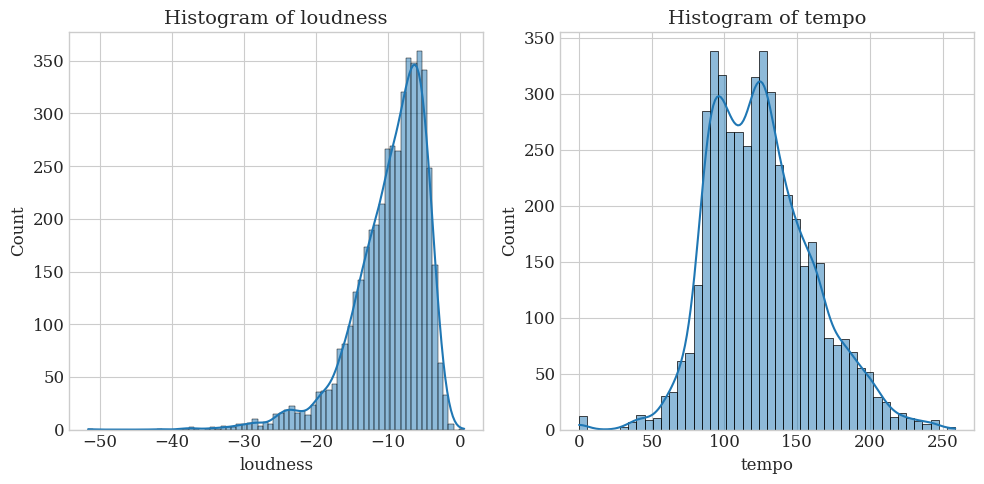

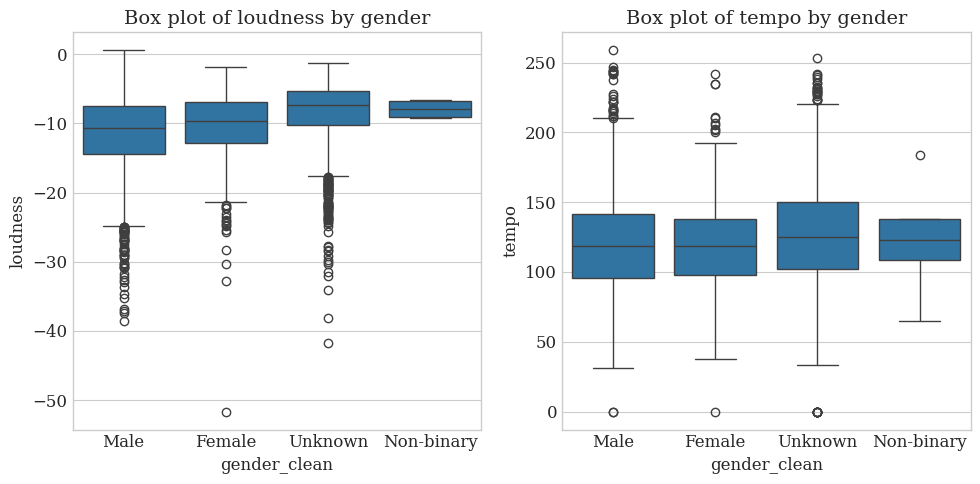

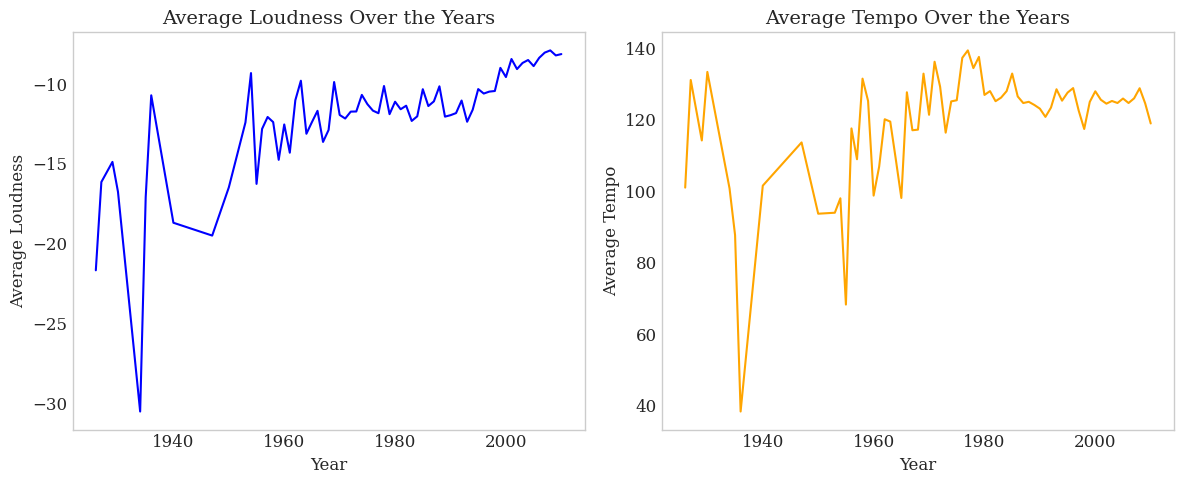

In [38]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('final.csv')

# Select relevant columns for analysis
relevant_columns = ['year', 'gender_clean', 'loudness', 'tempo']
df_relevant = df[relevant_columns].dropna()

# Display the first few rows of the relevant data
print("First few rows of the relevant data:")
print(df_relevant.head())

# Summary statistics for the relevant numerical columns
print("\nSummary statistics for relevant numerical columns:")
print(df_relevant.describe())

# Histograms for numerical acoustic features
acoustic_features = ['loudness', 'tempo']

plt.figure(figsize=(10, 5))
for i, feature in enumerate(acoustic_features, 1):
    plt.subplot(1, 2, i)
    sns.histplot(df_relevant[feature], kde=True)
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

# Box plots for acoustic features by gender
plt.figure(figsize=(10, 5))
for i, feature in enumerate(acoustic_features, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=df_relevant, x='gender_clean', y=feature)
    plt.title(f'Box plot of {feature} by gender')
plt.tight_layout()
plt.show()

# Separate line plots for average loudness and tempo over the years
plt.figure(figsize=(12, 5))

# Average loudness over the years
plt.subplot(1, 2, 1)
df_relevant.groupby('year')['loudness'].mean().plot(color='blue')
plt.title('Average Loudness Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Loudness')
plt.grid()

# Average tempo over the years
plt.subplot(1, 2, 2)
df_relevant.groupby('year')['tempo'].mean().plot(color='orange')
plt.title('Average Tempo Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Tempo')
plt.grid()

plt.tight_layout()
plt.show()


# Part 2: Visualization

**3D t-SNE Visualization for Musical Acoustical Similarity**

This section provides an interactive 3D t-SNE visualization of the acoustic feature set. You can filter by gender, country, genre, and year range, and dynamically recolor the projection.

**1. Dash App Initialization with Modern Font**

In [26]:
df = pd.read_csv("final.csv")

external_stylesheets = [
    {
        "href": "https://fonts.googleapis.com/css2?family=Inter+Tight:wght@300;400;500;600;700&display=swap",
        "rel": "stylesheet",
    }
]

# Initialize the Dash app
app = Dash(__name__, external_stylesheets=external_stylesheets)

# Base metadata required
required_base_cols = ["genre_principal", "artist_name", "title", "year", "gender", "country"]
# Audio feature set
timbre_cols = [f"timbre_{i}_mean" for i in range(12)]
pitch_cols = [f"pitch_{i}_mean" for i in range(12)]
additional_audio_cols = ["key", "mode", "tempo", "time_signature", "loudness"]
feature_cols = timbre_cols + pitch_cols + additional_audio_cols
required_cols = required_base_cols + feature_cols

# Column presence check
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' missing from final.csv")

**2. Data cleaning**

In [27]:
df["year_int"] = df["year"].astype("Int64")
df["year_clean"] = df["year_int"].astype(str)

def clean_gender(g):
    """Normalize gender values into Male / Female / Unknown."""
    if isinstance(g, str):
        gl = g.lower()
        if "female" in gl:
            return "Female"
        if "male" in gl:
            return "Male"
    return "Unknown"

df["gender_clean"] = df["gender"].apply(clean_gender)

def convert_country(c):
    """Convert ISO alpha-2/3 country codes to full names; otherwise title-case string."""
    if not isinstance(c, str) or not c.strip():
        return "Unknown"
    code = c.strip().upper()
    ctry = pycountry.countries.get(alpha_2=code) or pycountry.countries.get(alpha_3=code)
    return ctry.name if ctry else c.title()

df["country_clean"] = df["country"].apply(convert_country)

def country_to_continent(name):
    """Map country name to continent name using pycountry_convert."""
    try:
        ctry = pycountry.countries.get(name=name)
        if not ctry:
            return "Unknown"
        cont = pc.country_alpha2_to_continent_code(ctry.alpha_2)
        return pc.convert_continent_code_to_continent_name(cont)
    except Exception:
        return "Unknown"

df["continent_clean"] = df["country_clean"].apply(country_to_continent)


**3.Compute t-SNE Embedding (once at launch)**

In [28]:
# Keep only rows with a declared genre
all_genres = sorted(df["genre_principal"].dropna().unique())
subset = df[df["genre_principal"].isin(all_genres)].copy()
# Drop rows with missing acoustic features (timbre + pitch)
subset = subset.dropna(subset=timbre_cols + pitch_cols).copy()
# Build feature matrix for the acoustic embedding (29 dimensions)
X = subset[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
tsne = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    metric="euclidean",
    random_state=42,
)
X_tsne = tsne.fit_transform(X_scaled)
# Build visualization dataframe
vis_df = subset.copy()
vis_df["tsne_1"] = X_tsne[:, 0]
vis_df["tsne_2"] = X_tsne[:, 1]
vis_df["tsne_3"] = X_tsne[:, 2]
vis_df = vis_df.reset_index(drop=False).rename(columns={"index": "row_id"})
vis_df = vis_df[
    [
        "row_id",
        "tsne_1",
        "tsne_2",
        "tsne_3",
        "title",
        "artist_name",
        "year_int",
        "year_clean",
        "gender_clean",
        "country_clean",
        "continent_clean",
        "genre_principal",
    ]
]


**4.User Interface**

In [29]:
available_genders = sorted(vis_df["gender_clean"].unique())
available_countries = sorted(vis_df["country_clean"].unique())
available_genres = sorted(vis_df["genre_principal"].unique())
available_continents = sorted(vis_df["continent_clean"].unique())
year_min = int(vis_df["year_int"].min())
year_max = int(vis_df["year_int"].max())
unique_years = sorted(vis_df["year_int"].dropna().unique())
marks = (
    {int(y): str(int(y)) for y in unique_years}
    if len(unique_years) <= 20
    else {y: str(y) for y in range(year_min, year_max + 1, max((year_max - year_min) // 10, 1))}
)

app.layout = html.Div(
    style={"backgroundColor": "#1e1e1e", "color": "white", "fontFamily": "'Inter Tight', sans-serif"},
    children=[
        html.H1(
            "Navigating the Musical Landscape: 3D Similarity Map",
            style={"textAlign": "center", "fontWeight": "600", "marginBottom": "20px"},
        ),
        # Filters (Color-by placed on the left)
        html.Div(
            style={
                "display": "flex",
                "gap": "40px",
                "marginBottom": "20px",
                "justifyContent": "center",
            },
            children=[
                # 1. Color points by (moved to the left)
                html.Div(
                    style={"minWidth": "220px"},
                    children=[
                        html.Label("Color points by"),
                        dcc.Dropdown(
                            id="color-by",
                            className="dark-dropdown",
                            options=[
                                {"label": "Genre", "value": "genre_principal"},
                                {"label": "Gender", "value": "gender_clean"},
                                {"label": "Continent", "value": "continent_clean"},
                            ],
                            value="genre_principal",
                            clearable=False,
                        ),
                    ],
                ),
                # 2. Gender
                html.Div(
                    style={"minWidth": "220px"},
                    children=[
                        html.Label("Gender"),
                        dcc.Checklist(
                            id="gender-filter",
                            options=[{"label": g, "value": g} for g in available_genders],
                            value=available_genders,
                            inline=True,
                            style={"color": "white"},
                        ),
                    ],
                ),
                # 3. Country
                html.Div(
                    style={"minWidth": "220px"},
                    children=[
                        html.Label("Country"),
                        dcc.Dropdown(
                            id="country-filter",
                            className="dark-dropdown",
                            options=[{"label": c, "value": c} for c in available_countries],
                            value=available_countries,
                            multi=True,
                        ),
                    ],
                ),
                # 4. Genre
                html.Div(
                    style={"minWidth": "220px"},
                    children=[
                        html.Label("Genre"),
                        dcc.Dropdown(
                            id="genre-filter",
                            className="dark-dropdown",
                            options=[{"label": g, "value": g} for g in available_genres],
                            value=available_genres,
                            multi=True,
                        ),
                    ],
                ),
            ],
        ),
        # Year slider
        html.Div(
            children=[
                html.Label("Year range"),
                dcc.RangeSlider(
                    id="year-range",
                    min=year_min,
                    max=year_max,
                    value=[year_min, year_max],
                    marks=marks,
                ),
            ]
        ),
        # Graph + Panel
        html.Div(
            style={"display": "flex", "gap": "20px"},
            children=[
                html.Div(
                    style={"flex": "3"},
                    children=[dcc.Graph(id="tsne-3d-graph", style={"height": "750px"})],
                ),
                html.Div(
                    id="right-panel",
                    style={
                        "flex": "2",
                        "backgroundColor": "#2a2a2a",
                        "padding": "15px",
                        "borderRadius": "8px",
                        "overflowY": "auto",
                        "height": "750px",
                    },
                    children=[
                        html.H3("Selected track"),
                        html.Div(id="selected-track"),
                        html.H3("5 nearest neighbors", style={"marginTop": "20px"}),
                        html.Div(id="neighbors-table"),
                    ],
                ),
            ],
        ),
    ],
)

**5.Callback**

In [30]:
@app.callback(
    Output("tsne-3d-graph", "figure"),
    Output("selected-track", "children"),
    Output("neighbors-table", "children"),
    [
        Input("gender-filter", "value"),
        Input("country-filter", "value"),
        Input("genre-filter", "value"),
        Input("year-range", "value"),
        Input("color-by", "value"),
        Input("tsne-3d-graph", "clickData"),
    ],
)
def update_tsne(selected_genders, selected_countries, selected_genres, year_range, color_by, clickData):
    """Update the t-SNE projection and metadata according to filter selections."""
    dff = vis_df.copy()
    # Filters
    if selected_genders:
        dff = dff[dff["gender_clean"].isin(selected_genders)]
    if selected_countries:
        dff = dff[dff["country_clean"].isin(selected_countries)]
    if selected_genres:
        dff = dff[dff["genre_principal"].isin(selected_genres)]
    if year_range:
        dff = dff[(dff["year_int"] >= year_range[0]) & (dff["year_int"] <= year_range[1])]
    # Remove Unknown when coloring by gender
    if color_by == "gender_clean":
        dff = dff[dff["gender_clean"] != "Unknown"]
    if dff.empty:
        return px.scatter_3d(), html.Div("No track selected."), html.Div("No data.")
    # Plot
    fig = px.scatter_3d(
        dff,
        x="tsne_1",
        y="tsne_2",
        z="tsne_3",
        color=color_by,
        opacity=0.95,
        labels={
            "genre_principal": "Genre",
            "gender_clean": "Gender",
            "continent_clean": "Continent",
        }
    )
    fig.update_traces(marker=dict(size=2))
    fig.update_layout(
        paper_bgcolor="#1e1e1e",
        plot_bgcolor="#1e1e1e",
        scene=dict(
            bgcolor="#1e1e1e",
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
        ),
        font=dict(color="white"),
        legend=dict(font=dict(color="white")),
    )
    # Hover
    for trace in fig.data:
        mask = dff[color_by] == trace.name
        trace.customdata = dff.loc[
            mask,
            [
                "row_id",
                "title",
                "artist_name",
                "year_clean",
                "gender_clean",
                "country_clean",
                "continent_clean",
                "genre_principal",
            ],
        ].values
        trace.hovertemplate = (
            "<b>%{customdata[1]}</b><br>"
            "Artist: %{customdata[2]}<br>"
            "Year: %{customdata[3]}<br>"
            "Gender: %{customdata[4]}<br>"
            "Country: %{customdata[5]}<br>"
            "Continent: %{customdata[6]}<br>"
            "Genre: %{customdata[7]}<br>"
            "<extra></extra>"
        )
    # Default panels
    selected_track = html.Div("Click a point.")
    neighbors_table = html.Div("Click a point.")
    # If a point is selected
    if clickData and "points" in clickData:
        custom = clickData["points"][0].get("customdata")
        if custom is not None:
            clicked_id = int(custom[0])
            if clicked_id in dff["row_id"].values:
                selected_row = dff[dff["row_id"] == clicked_id].iloc[0]
                selected_track = html.Div(
                    [
                        html.H4(selected_row["title"]),
                        html.P(f"Artist: {selected_row['artist_name']}"),
                        html.P(f"Year: {selected_row['year_clean']}"),
                        html.P(f"Gender: {selected_row['gender_clean']}"),
                        html.P(f"Country: {selected_row['country_clean']}"),
                        html.P(f"Continent: {selected_row['continent_clean']}"),
                        html.P(f"Genre: {selected_row['genre_principal']}"),
                    ]
                )
                coords = dff[["tsne_1", "tsne_2", "tsne_3"]].values
                target = selected_row[["tsne_1", "tsne_2", "tsne_3"]].values.astype(float)
                dist = np.linalg.norm(coords - target, axis=1)
                temp = dff.copy()
                temp["distance"] = dist
                neighbors = temp[temp["row_id"] != clicked_id].sort_values("distance").head(5)
                rows = [
                    html.Tr(
                        [
                            html.Td(r["title"]),
                            html.Td(r["artist_name"]),
                            html.Td(str(r["year_clean"])),
                            html.Td(r["country_clean"]),
                            html.Td(r["genre_principal"]),
                            html.Td(f"{r['distance']:.3f}"),
                        ]
                    )
                    for _, r in neighbors.iterrows()
                ]
                neighbors_table = html.Table(
                    [
                        html.Tr(
                            [
                                html.Th("Title"),
                                html.Th("Artist"),
                                html.Th("Year"),
                                html.Th("Country"),
                                html.Th("Genre"),
                                html.Th("Dist"),
                            ]
                        )
                    ]
                    + rows,
                    style={"width": "100%"},
                )
    return fig, selected_track, neighbors_table

**6.Run application in the notebook**

In [34]:
app.run(host='0.0.0.0', port=8052, debug=False)
print(f"Dash app is running on http://localhost:8052/")

Dash app is running on http://localhost:8052/


# Part 3: Analysis 

**1. Data Loading and Cleaning**

Load the dataset and clean the gender variable for binary analysis

In [ ]:
def classify_gender_robust(g):
    """Robustly classifies gender using regex for binary analysis."""
    if pd.isna(g) or str(g).lower() == 'nan':
        return "Unknown"
    g = str(g).lower().strip()
    if re.search(r'\b(female|woman|femme|girl|women)\b', g):
        return "Female"
    elif re.search(r'\b(male|man|homme|boy|men)\b', g) and not re.search(r'fe(male)|wo(man|men)', g):
        return "Male"
    elif re.search(r'\b(non-binary|nonbinary|genderqueer|agender)\b', g):
        return "Non-binary"
    else:
        return "Unknown"

try:
    df = pd.read_csv("final.csv")
    df["gender_clean"] = df["gender"].apply(classify_gender_robust)
    print(f"Data Loading Successful: {len(df)} rows.")
    print("\nCleaned Gender Distribution:")
    print(df["gender_clean"].value_counts().to_string())
except FileNotFoundError:
    print("ERROR: 'final.csv' not found.")
    exit()

# %%
# Filter for binary analysis (Male/Female)
ACOUSTIC_VARS = [f"timbre_{i}_mean" for i in range(12)] + \
                [f"pitch_{i}_mean" for i in range(12)] + \
                ["loudness", "tempo", "energy", "danceability"]

df_binary = df[df["gender_clean"].isin(["Male", "Female"])].copy()
required_cols = ACOUSTIC_VARS + ["artist_name", "gender_clean"]
if "genre_principal" in df.columns:
    required_cols.append("genre_principal")
df_binary = df_binary.dropna(subset=required_cols)

# Exclude constant variables
initial_vars = list(ACOUSTIC_VARS)
constant_vars = [var for var in initial_vars if df_binary[var].nunique() <= 1]
if constant_vars:
    print(f"\nWARNING: Constant variables excluded (Zero variance): {constant_vars}")
    ACOUSTIC_VARS = [var for var in initial_vars if var not in constant_vars]

print(f"\nTracks for Binary Analysis (Male/Female) after Filtering: {len(df_binary)}")
X = df_binary[ACOUSTIC_VARS].values
y = df_binary["gender_clean"].map({"Male": 0, "Female": 1}).values

**2. Univariate Statistics (Welch T-Test & FDR)**

Test for significant differences in acoustic features between genders


In [ ]:
results_uni = []
for var in ACOUSTIC_VARS:
    male_group = df_binary[df_binary.gender_clean == "Male"][var]
    female_group = df_binary[df_binary.gender_clean == "Female"][var]
    stat, p = stats.ttest_ind(male_group, female_group, equal_var=False)
    pooled_std = np.sqrt(((len(male_group)-1) * male_group.var(ddof=1) + (len(female_group)-1) * female_group.var(ddof=1)) / (len(male_group) + len(female_group) - 2))
    d = (male_group.mean() - female_group.mean()) / pooled_std if pooled_std > 1e-10 and (len(male_group) + len(female_group) - 2) > 0 else np.nan
    results_uni.append({"Variable": var, "P-value": p, "Cohens_d": d})

df_uni = pd.DataFrame(results_uni)
_, df_uni["P_FDR"] = fdrcorrection(df_uni["P-value"].fillna(1))
df_uni["Significant"] = df_uni["P_FDR"] < 0.05

print(df_uni.sort_values("P_FDR").head(10)[["Variable", "P_FDR", "Cohens_d", "Significant"]].to_string())
print("\n*P_FDR < 0.05 indicates significance after controlling for multiple comparisons (H1).*")


# Plot the most significant variable
if not df_uni[df_uni['Significant']].empty:
    top_sig_var = df_uni[df_uni['Significant']].sort_values('P_FDR').iloc[0]['Variable']
    plt.figure(figsize=(8, 6))
    sns.boxplot(
    x="gender_clean",
    y=top_sig_var,
    hue="gender_clean",  # Add this
    data=df_binary,
    palette=GENDER_PALETTE,
    legend=False,        # Add this
    order=["Male", "Female"],
    linewidth=1,
    notch=False,
    medianprops={'color': 'black', 'linewidth': 1.5},
    boxprops={'alpha': 0.8}
    )
    plt.title(f"Figure 1: Distribution of {top_sig_var} by Artist Gender", weight='bold', pad=15)
    plt.xlabel("Artist Gender")
    plt.ylabel(top_sig_var)
    plt.show()

**3. Classification & Permutation Importance**

Use a Random Forest to classify gender and identify important features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='balanced_accuracy')
print(f"Random Forest Balanced Accuracy (5-Fold CV): {scores.mean():.3f} (±{scores.std()*2:.3f})")

rf_pipeline.fit(X_train, y_train)
perm_importance = permutation_importance(rf_pipeline, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, scoring='balanced_accuracy')
df_imp = pd.DataFrame({
    'Variable': ACOUSTIC_VARS,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print("\nTop 5 Variables (Permutation Importance on Test Set):")
print(df_imp.head(5).to_string())


# Plot feature importance
df_plot = df_imp.head(15).copy()
IMPORTANCE_PALETTE = sns.color_palette("viridis", n_colors=len(df_plot))
plt.figure(figsize=(10, 8))
sns.barplot(
    data=df_plot,
    x="Importance",
    y="Variable",
    hue="Variable",  # Assign the `y` variable to `hue`
    palette=IMPORTANCE_PALETTE,
    edgecolor='black',
    linewidth=1,
    errorbar=None,
    legend=False  # Disable the legend to avoid redundancy
    )
plt.errorbar(
    df_plot["Importance"],
    df_plot["Variable"],
    xerr=df_plot["Std"],
    fmt='none',
    c='dimgray',
    capsize=5
)
plt.title("Figure 2: Permutation Importance for Gender Classification (H2)", weight='bold', pad=15)
plt.xlabel("Mean Drop in Balanced Accuracy (Importance)")
plt.ylabel("Acoustic Variable")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**4. Mixed-Effects Models & Interaction Plot**

Test the robustness of gender effects controlling for artist and genre

In [ ]:
df_mixed = df_binary.copy()
current_acoustic_vars = list(ACOUSTIC_VARS)
artist_counts = df_mixed["artist_name"].value_counts()
artists_to_keep = artist_counts[artist_counts >= 2].index
df_mixed = df_mixed[df_mixed["artist_name"].isin(artists_to_keep)].copy()
print(f"Observations for LMM after filtering single-track artists: {len(df_mixed)}")

current_acoustic_vars = [col for col in current_acoustic_vars if df_mixed[col].std() > 1e-10]
for col in current_acoustic_vars:
    df_mixed[col] = (df_mixed[col] - df_mixed[col].mean()) / df_mixed[col].std()

if not df_imp.empty and not df_mixed.empty:
    df_imp_filtered = df_imp[df_imp['Variable'].isin(current_acoustic_vars)]
    top_var = df_imp_filtered.iloc[0]['Variable'] if not df_imp_filtered.empty else current_acoustic_vars[0]
    print(f"\nIn-depth analysis for top feature: {top_var}")

    formula = f"{top_var} ~ C(gender_clean)"
    if 'genre_principal' in df_mixed.columns:
        genre_val_counts = df_mixed['genre_principal'].value_counts()
        valid_genres = genre_val_counts[genre_val_counts >= 5].index
        df_mixed_lmm = df_mixed[df_mixed['genre_principal'].isin(valid_genres)].copy()
        if len(df_mixed_lmm) > 0 and 1 < valid_genres.nunique() < 100:
            print("-> Adding 'genre_principal' control (Musical Style)")
            formula += " + C(genre_principal)"
            df_mixed_lmm['genre_principal'] = df_mixed_lmm['genre_principal'].astype('category')
            df_mixed = df_mixed_lmm

    print(f"LMM Formula: {formula} | Random Effect: Artist Name")
    try:
        model = smf.mixedlm(formula, df_mixed, groups=df_mixed["artist_name"])
        result = model.fit(method='lbfgs', maxiter=500)
        print("\n--- MIXED MODEL RESULTS (Artist Control) ---")
        print(result.summary().tables[1].to_string())
        coef = result.params.get("C(gender_clean)[T.Male]", None)
        pval = result.pvalues.get("C(gender_clean)[T.Male]", None)
        if coef is not None:
            print(f"\n**Result for {top_var} (after controlling Artist/Genre):**")
            print(f"Male Coefficient: {coef:.3f}")
            print(f"P-value: {pval:.5f}")
            if pval < 0.05:
                print("=> Gender effect is **significant** (H3: Robustness confirmed).")
            else:
                print("=> Gender effect is **not significant** (H3: Effect absorbed by artist/style).")
    except Exception as e:
        print(f"The Mixed Model failed (convergence or singularity issue): {e}")

    if 'genre_principal' in df_binary.columns and not df_imp.empty:
        top_genres = df_binary['genre_principal'].value_counts().head(5).index
        df_plot_interaction = df_binary[df_binary['genre_principal'].isin(top_genres)].copy()
        if df_plot_interaction['genre_principal'].nunique() >= 2 and not df_plot_interaction.empty:
            print(f"\nTracing Interaction Plot (H3) for {len(df_plot_interaction)} observations across {df_plot_interaction['genre_principal'].nunique()} top genres.")
            df_plot_interaction[top_var] = (df_plot_interaction[top_var] - df_plot_interaction[top_var].mean()) / df_plot_interaction[top_var].std()
            plt.figure(figsize=(12, 8))
            sns.boxplot(
                data=df_plot_interaction,
                x="genre_principal",
                y=top_var,
                hue="gender_clean",
                palette=GENDER_PALETTE,
                linewidth=0.8,
                fliersize=2,
                order=top_genres,
                boxprops={'alpha': 0.8}
            )
            plt.title(f"Figure 3: Interaction of {top_var} by Gender across Top Genres (H3)", weight='bold', pad=15)
            plt.xlabel("Principal Genre")
            plt.ylabel(f"Standardized {top_var}")
            plt.legend(title='Artist Gender')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()


**5. PCA Visualization**

Explore the global structure of the acoustic data

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
comp = pca.fit_transform(X_scaled)
print(f"Variance Explained PC1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"Variance Explained PC2: {pca.explained_variance_ratio_[1]:.1%}")

df_pca = pd.DataFrame({
    "PC1": comp[:, 0],
    "PC2": comp[:, 1],
    "gender": df_binary["gender_clean"].values
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="gender",
    palette=GENDER_PALETTE,
    alpha=0.6,
    s=40,
    edgecolor='w',
    linewidth=0.5
)
plt.title("Figure 4: PCA Scores Plot of Acoustic Data by Artist Gender", weight='bold', pad=15)
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.legend(title='Artist Gender', title_fontsize=13, fontsize=11)
plt.tight_layout()
plt.show()

**6. Summary and Interpretation**

Key findings and implications for the report

### Analytical Objectives Accomplished:
1. **H1 (Significant Acoustic Differences):**
   - Verified via **Welch's T-Test** and **FDR correction**.
   - Visualized by **Figure 1 (Box Plot)** for the most significant variable.
2. **H2 (Specificity of Acoustic Dimensions):**
   - Verified via **Permutation Importance** of the Random Forest model.
   - Visualized by **Figure 2 (Feature Importance Bar Plot)**.
   - Note on Balanced Accuracy: The low score indicates **statistical** differences (H1) are too **subtle** for reliable **prediction** (H2).
3. **H3 (Interaction/Robustness against Contextual Bias):**
   - Explored for robustness using the **Mixed-Effects Model (LMM)**, controlling for 'Artist' and 'Genre Principal'.
   - Visualized by **Figure 3 (Interaction Box Plot)**, examining how the gender effect varies across top musical genres.

### Focus Principal:
The analysis strongly points to **Timbre** components as the key differentiators (H1, H2). The effect of gender on timbre is statistically **robust** (H3) even when accounting for artist-specific tendencies and genre styles, confirming that the difference is not merely an artifact of artist concentration within certain genres.
